In [1]:
import numpy as np
import math
import random
import os
import torch
from path import Path
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

/Users/aizhan/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/aizhan/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: /Users/aizhan/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 15.0.0 or later, but libjpeg.9.dylib provides version 14.0.0
  warn(f"Failed to load image Python extension: {e}")


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
path = Path("data/ModelNet10")
path

Path('data/ModelNet10')

In [4]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

In [5]:
from utils.preprocess import read_off

In [6]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
  verts, faces = read_off(f)
  print(len(verts))

2095


In [7]:
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

In [8]:
len(x)

2095

In [9]:
import utils.preprocess

In [10]:
train_transforms = transforms.Compose([
                    utils.preprocess.PointSampler(2048),
                    utils.preprocess.Normalize(),
                    utils.preprocess.RandRotation_z(),
                    utils.preprocess.RandomNoise(),
                    utils.preprocess.ToTensor()
                    ])

In [11]:
train_ds = utils.preprocess.PointCloudData(path, transform=train_transforms)
valid_ds = utils.preprocess.PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [12]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [13]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[900]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([2048, 3])
Class:  chair


In [14]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [16]:
import models.PointNet

In [17]:

pointnet = models.PointNet.PointNet()
pointnet.to(device)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [18]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [19]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs): 
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1,2))

            loss = models.PointNet.pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        model.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(model.state_dict(), "save_"+str(epoch)+".pth")

In [20]:
train(pointnet, train_loader, valid_loader,  save=False)

[Epoch: 1, Batch:   10 /  125], loss: 1.981
[Epoch: 1, Batch:   20 /  125], loss: 1.607
[Epoch: 1, Batch:   30 /  125], loss: 1.546
[Epoch: 1, Batch:   40 /  125], loss: 1.391
[Epoch: 1, Batch:   50 /  125], loss: 1.260
[Epoch: 1, Batch:   60 /  125], loss: 1.400
[Epoch: 1, Batch:   70 /  125], loss: 1.232
[Epoch: 1, Batch:   80 /  125], loss: 1.090
[Epoch: 1, Batch:   90 /  125], loss: 0.951
[Epoch: 1, Batch:  100 /  125], loss: 0.908
[Epoch: 1, Batch:  110 /  125], loss: 1.010
[Epoch: 1, Batch:  120 /  125], loss: 0.916
Valid accuracy: 56 %
[Epoch: 2, Batch:   10 /  125], loss: 0.936
[Epoch: 2, Batch:   20 /  125], loss: 0.936
[Epoch: 2, Batch:   30 /  125], loss: 0.822
[Epoch: 2, Batch:   40 /  125], loss: 0.849
[Epoch: 2, Batch:   50 /  125], loss: 0.768
[Epoch: 2, Batch:   60 /  125], loss: 0.759
[Epoch: 2, Batch:   70 /  125], loss: 0.755
[Epoch: 2, Batch:   80 /  125], loss: 0.719
[Epoch: 2, Batch:   90 /  125], loss: 0.793
[Epoch: 2, Batch:  100 /  125], loss: 0.670
[Epoch: 2, 

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
#pointnet.load_state_dict(torch.load('save_14.pth'))
pointnet.eval();

In [23]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.cpu().numpy())

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]


In [24]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[40,  7,  0,  0,  0,  0,  0,  1,  1,  1],
       [ 0, 88,  1,  0,  0,  0,  0,  1, 10,  0],
       [ 0,  0, 98,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  1, 64,  1,  0,  3,  4, 13,  0],
       [ 0,  0,  0,  0, 64,  3, 14,  0,  1,  4],
       [ 0,  0,  1,  0,  0, 90,  0,  0,  0,  9],
       [ 0,  0,  1,  2, 14,  0, 50,  0, 15,  4],
       [ 0,  4,  2,  1,  0,  0,  0, 91,  0,  2],
       [ 0,  0,  0,  6,  0,  0,  0,  0, 94,  0],
       [ 1,  0,  1,  0,  0,  0,  0,  0,  0, 98]])

In [25]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


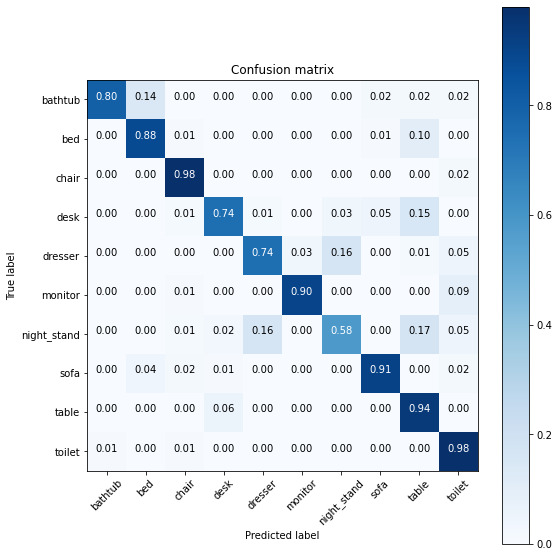

In [26]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)